## emupy v1.0.0 worked example with simulation data from 21cmFAST

**Nick Kern**
<br>
**November, 2020**

---

Here we will create interpolation functions (an emulator) for the spherically-averaged 21cm brightness temperature power spectrum $P_{21}(k,z)$. The data itself are actually in the units $\Delta^{2}_{21}(k,z) = P_{21}(k,z)k^{3}/(2\pi^{2})\ [\rm{mK}^{2}]$. The data in `lh_training.pkl` are drawn from a random Latin-Hypercube design in a **three dimensional** model parameter space of the UV ionizing efficiency parameter ($\zeta$), the virial temperature of star-forming halos ($T_{vir}^{min}$), and the mean-free path of ionizing photons through ionized regions ($R_{mfp}$). See [Kern et al. 2017](https://arxiv.org/abs/1705.04688) for parameterization details. The data in `cross_inspection.pkl` are drawn from a uniform grid across each individual parameter while holding all others constant. 

The example below has certain code dependencies. See [emupy](github.com/nkern/emupy) for dependency details and installation instructions.

In [1]:
# Import modules
%matplotlib inline
import numpy as np
import emupy
import pickle as pkl
import sklearn.gaussian_process as gp
import astropy.stats as astats
import matplotlib.pyplot as plt
import torch

In [2]:
# Load some training data
with open('lh_training.pkl','rb') as f:
    dic = pkl.load(f, encoding='latin1')
    data = dic['data']
    grid = dic['grid']
    
# Load cross-data
with open('cross_inspection.pkl','rb') as f:
    dic = pkl.load(f, encoding='latin1')
    data_cr = dic['data']
    grid_cr = dic['grid']
    # Sort the cross_inspection data and split into three individual data sets
    fid_grid = np.median(grid_cr, axis=0)
    sort1 = np.where((grid_cr.T[1]==fid_grid[1])&(grid_cr.T[2]==fid_grid[2]))[0]
    sort2 = np.where((grid_cr.T[0]==fid_grid[0])&(grid_cr.T[2]==fid_grid[2]))[0]
    sort3 = np.where((grid_cr.T[0]==fid_grid[0])&(grid_cr.T[1]==fid_grid[1]))[0]
    data_cr1, grid_cr1 = data_cr[sort1], grid_cr[sort1]
    data_cr2, grid_cr2 = data_cr[sort2], grid_cr[sort2]
    data_cr3, grid_cr3 = data_cr[sort3], grid_cr[sort3]
    
# Randomly select from data_tr and assign to cross-validation set data_cv
rng = np.random.RandomState(1)
rando = rng.choice(np.arange(len(data)), replace=False, size=500)
select = np.array(np.zeros(len(data)), dtype=bool)
select[rando] = True
data_tr = data[select]
grid_tr = grid[select]
data_cv = data[~select]
grid_cv = grid[~select]

# Load in k-data of power spectra
k_range = np.loadtxt('k_range.tab')
k_vals = np.array([k_range for i in range(3)]).ravel()
z_vals = np.array([np.arange(8,11) for i in range(11)]).T.ravel()
kz_info = np.array(list(zip(k_vals, z_vals)))

`data_tr` is the array containing our training data y-values. It has shape `(200, 33)`, which corresponds to 200 individual samples within our 3-dimensional model space, each with 33 individual data elements of $\Delta^{2}_{21}$ that we want to emulate. The 33 elements of the data correspond to the power spectrum across 11 $k$ values found in `k_range` at redshifts $z = [8, 9, 10]$.

`grid_tr` is the array containing the training data x-values. It has shape `(200, 3)`, which corresponds to the 200 individual samples within our 3-dimensional model space, each with a unique vector position in the 3-d parameter space.

Text(0, 0.5, '$R_{mfp}\\ [{pltc}]$')

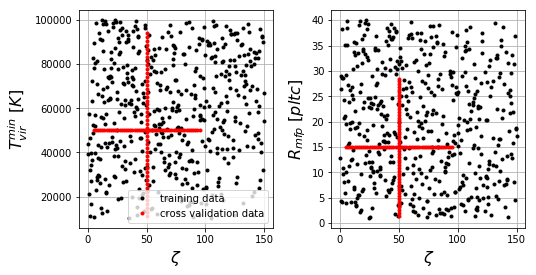

In [3]:
# Plot training data x-values
fig = plt.figure(figsize=(8,4))
fig.subplots_adjust(wspace=0.3)

ax = fig.add_subplot(121)
ax.grid(True)
p0, = ax.plot(grid_tr.T[0], grid_tr.T[1], 'k.')
p1, = ax.plot(grid_cr1.T[0], grid_cr1.T[1], 'r.')
ax.plot(grid_cr2.T[0], grid_cr2.T[1], 'r.')
ax.set_xlabel('$\zeta$', fontsize=16)
ax.set_ylabel('$T_{vir}^{min}\ [{K}]$', fontsize=16)
ax.legend([p0,p1],['training data', 'cross validation data'])

ax = fig.add_subplot(122)
ax.grid(True)
ax.plot(grid_tr.T[0], grid_tr.T[2], 'k.')
ax.plot(grid_cr1.T[0], grid_cr1.T[2], 'r.')
ax.plot(grid_cr3.T[0], grid_cr3.T[2], 'r.')
ax.set_xlabel('$\zeta$', fontsize=16)
ax.set_ylabel('$R_{mfp}\ [{pltc}]$', fontsize=16)

__Figure 1__ | Training data feature values across the three dimensional astrophysical parameter space. Black points are the training data, red points are the cross-validation data drawn specifically to show the behavior of the prediction wrt each parameter indepedently.

In [10]:
# initialize emulator
E = emupy.NNEmulator()

# scale training target data
E.scale_data(data_tr, lognorm=True, center=False, whiten=False, save_scaling=True);

# sphere training feature data
E.sphere(grid_tr, save=True);

In [11]:
# setup NN if NN emulating
np.random.seed(0)
torch.set_default_dtype(torch.float64)
layers = [torch.nn.Linear(3, 50), torch.nn.Linear(50, 100), torch.nn.Linear(100, 33)]
inits = [torch.nn.init.xavier_normal, torch.nn.init.xavier_normal, torch.nn.init.xavier_normal]
activations = [torch.nn.Tanh(), torch.nn.Tanh(), None]
E.set_layers(layers)
E.set_inits(inits)
E.set_activations(activations)

In [12]:
# train
E.train(E.Xsph, E.y_scaled, Nepochs=1000)

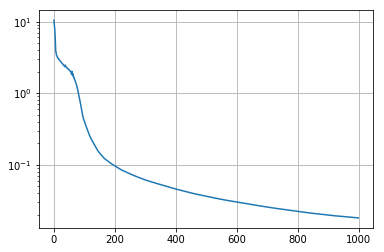

In [13]:
plt.plot(E.loss)
plt.yscale('log')
plt.grid()

In [14]:
# Make predictions across cross_inspection data x-values
cr1_pred = E.predict(E.sphere(grid_cr1, Xmean=E.Xmean, L=E.L), unscale=True)
cr2_pred = E.predict(E.sphere(grid_cr2, Xmean=E.Xmean, L=E.L), unscale=True)
cr3_pred = E.predict(E.sphere(grid_cr3, Xmean=E.Xmean, L=E.L), unscale=True)

Text(0.5, 0, '$R_{mfp}$')

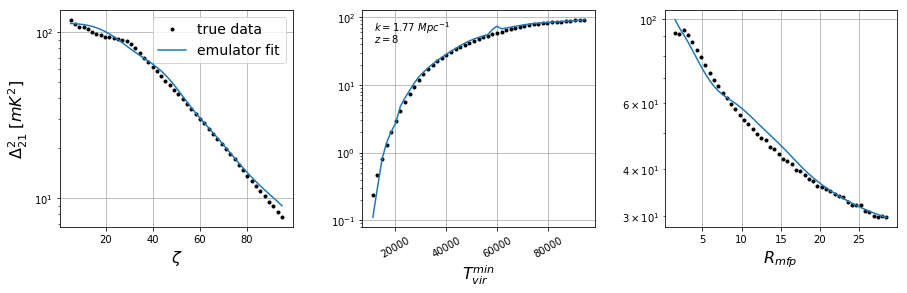

In [20]:
# Choose which bandpower to inspect
i = 10

# Initialize figure
fig = plt.figure(figsize=(15,4))
fig.subplots_adjust(wspace=0.3)

# Look across zeta
ax=fig.add_subplot(131)
ax.grid(True)
p0, = ax.plot(grid_cr1[:,0], data_cr1[:,i], 'k.')
p1, = ax.plot(grid_cr1[:,0], cr1_pred[:,i])
ax.set_yscale('log')
ax.set_xlabel('$\zeta$', fontsize=16)
ax.set_ylabel('$\Delta^{2}_{21}\ [mK^{2}]$', fontsize=16)
ax.legend([p0, p1], ['true data', 'emulator fit'], fontsize=14)

# Look across Tvir
ax=fig.add_subplot(132)
ax.grid(True)
p0, = ax.plot(grid_cr2[:,1], data_cr2[:,i], 'k.')
p1, = ax.plot(grid_cr2[:,1], cr2_pred[:,i])
[t.set_rotation(30) for t in ax.get_xticklabels()]
ax.set_yscale('log')
ax.set_xlabel('$T_{vir}^{min}$', fontsize=16)
ax.annotate("$k = %0.2f\ Mpc^{-1}$" % kz_info[i][0], (0.05,0.9), xycoords='axes fraction', fontsize=10)
ax.annotate("$z = %d$" % kz_info[i][1], (0.05,0.85), xycoords='axes fraction', fontsize=10)

# Look across Rmfp
ax=fig.add_subplot(133)
ax.grid(True)
p0, = ax.plot(grid_cr3[:,2], data_cr3[:,i], 'k.')
p1, = ax.plot(grid_cr3[:,2], cr3_pred[:,i])
ax.set_yscale('log')
ax.set_xlabel('$R_{mfp}$', fontsize=16)